In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0,"../")

In [ ]:
from torch.utils.data import DataLoader
import torch

In [ ]:
import random
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
from core.model.model import MoCo_scene_and_view as MoCo
from core.dataloader import CLEVR_train, collate_boxes, CLEVR_train_onlyquery, collate_boxes_onlyquery
from core.utils import compute_features

In [ ]:
# # kmeans_train_dataset = CLEVR_train_onlyquery(root_dir='/home/mprabhud/dataset/clevr_lang/npys/aa_5v.txt')
# # kmeans_train_loader = DataLoader(kmeans_train_dataset, batch_size=16, shuffle=False, collate_fn=collate_boxes_onlyquery)

# query_train_dataset = CLEVR_train(root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5t.txt', hyp_N=2, q_IDX=3)
# query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=False, collate_fn=collate_boxes)

In [ ]:
PATH = "../tb_logs/two_obj_spatial_with_scene_and_view_loss_exp30/checkpoint_299.pth.tar"
state_dict = torch.load(PATH)['state_dict']
view_r = state_dict["queue_view"].shape[1]
scene_r = state_dict["queue_scene"].shape[1]

model = MoCo(mode="spatial", scene_r=scene_r, view_r=view_r)
model = model.cuda()

model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
from attrdict import AttrDict

args = AttrDict({
    'mode':"spatial",
    'hyp_N':2
})

In [ ]:
from core.dataloader import sample_same_scene_negs
from vis_utils import *

In [ ]:
import time
t = 1000 * time.time() # current time in milliseconds
np.random.seed(int(t) % 2**32)

Initialised..... 10  files...
[2]


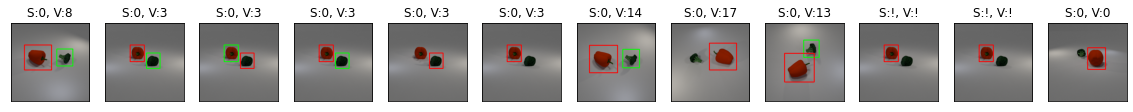

[2]


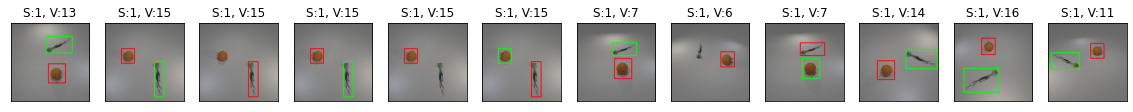

[1]


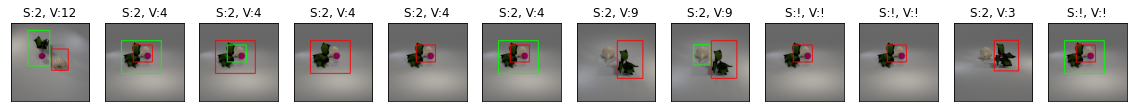

[1]


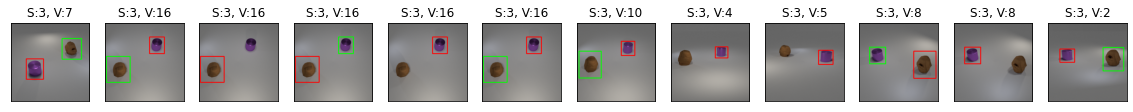

[2]


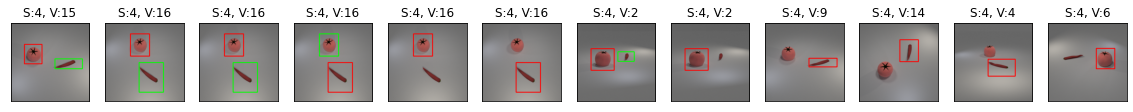

[2]


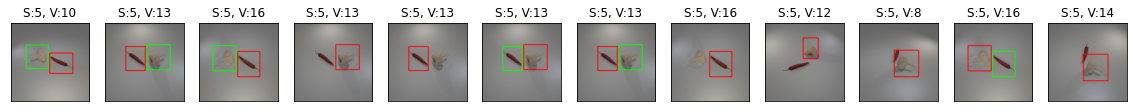

[2]


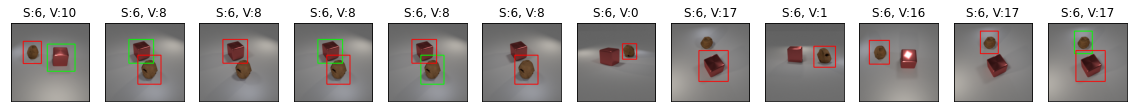

[2]


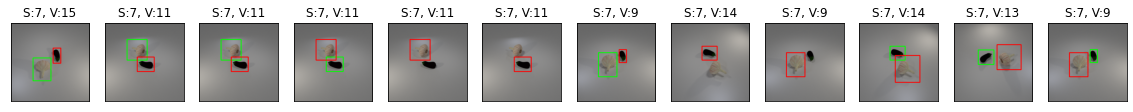

In [ ]:
pool_size = 63
pool_e_ = DoublePool_O(pool_size, isnode=False)
pool_g_ = DoublePool_O(2000, isnode=False)
pool_f_= DoublePool_O(pool_size, isnode=False)
query_train_dataset = CLEVR_train(root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5t.txt', hyp_N=2)
query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=False,collate_fn=collate_boxes)

for i, (feed_dict_q_, feed_dict_k_, metadata_) in enumerate((query_train_loader)):
    
    pool_size = 63
    pool_e_ = DoublePool_O(pool_size, isnode=False)
    pool_g_ = DoublePool_O(2000, isnode=False)
    pool_f_= DoublePool_O(pool_size, isnode=False)
    
    q_idx = metadata_["query_image_index"].item()
    k_idx = metadata_["key_image_index"].item()
    scene_num = metadata_["scene_number"].item()
    
#     q_idx = np.array((q_idx)).reshape(1,-1)
#     k_idx = np.array((k_idx)).reshape(1,-1)
#     scene_num = numpy.array((scene_num)).reshape(1,-1)
    
    #Story the scene embedding of the 0th view
    store_to_pool_e(pool_e_, feed_dict_q_, metadata_, model,args, scene_num, q_idx)
    store_to_pool_e(pool_f_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    
    #store view transformed embeddings to pool_g
    store_to_pool_g(pool_g_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    
    #Store unview transformed embeddings of the other views
    store_to_pool_e(pool_g_, feed_dict_k_, metadata_, model, args, "!", "!")
    store_to_pool_e(pool_g_, feed_dict_k_, metadata_, model, args, "!", "!")
    
    feed_dict_n_lists = sample_same_scene_negs(feed_dict_q_, feed_dict_k_, metadata_, args.hyp_N, 16)[0]
    
    for feed_dict_n,view_idx in feed_dict_n_lists:
        #Store unview transformed embeddings of the other views
        store_to_pool_e(pool_g_, feed_dict_n, metadata_, model, args, scene_num, view_idx.item())
        
    f = random_retrieve_topk(args, pool_e_, pool_g_, pool_f_, imgs_to_view=1,k=10)

In [ ]:
pool_size = 63
pool_e_ = DoublePool_O(pool_size, isnode=False)
pool_g_ = DoublePool_O(2000, isnode=False)
pool_f_= DoublePool_O(pool_size, isnode=False)
query_train_dataset = CLEVR_train(root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5t.txt', hyp_N=2, q_IDX=0)
query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=False,collate_fn=collate_boxes)

for i, (feed_dict_q_, feed_dict_k_, metadata_) in enumerate((query_train_loader)):
    
    pool_size = 63
    pool_e_ = DoublePool_O(pool_size, isnode=False)
    pool_g_ = DoublePool_O(2000, isnode=False)
    pool_f_= DoublePool_O(pool_size, isnode=False)
    
    q_idx = metadata_["query_image_index"].item()
    k_idx = metadata_["key_image_index"].item()
    scene_num = metadata_["scene_number"].item()
    
#     q_idx = np.array((q_idx)).reshape(1,-1)
#     k_idx = np.array((k_idx)).reshape(1,-1)
#     scene_num = numpy.array((scene_num)).reshape(1,-1)
    
    store_to_pool_e(pool_e_, feed_dict_q_, metadata_, model,args, scene_num, q_idx)
    store_to_pool_e(pool_f_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    
    #store view transformed embeddings to pool_g
    store_to_pool_g(pool_g_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    
    feed_dict_n_lists = sample_same_scene_negs(feed_dict_q_, feed_dict_k_, metadata_, args.hyp_N, 16)[0]
    
    for feed_dict_n,view_idx in feed_dict_n_lists:
        #Store unview transformed embeddings of the other views
        store_to_pool_e(pool_g_, feed_dict_n, metadata_, model, args, scene_num, view_idx.item())
        
    f = random_retrieve_topk(args, pool_e_, pool_g_, pool_f_, imgs_to_view=1)
    

Initialised..... 10  files...


In [ ]:
pool_size = 63
pool_e_ = DoublePool_O(pool_size, isnode=False)
pool_g_ = DoublePool_O(2000, isnode=False)
pool_f_= DoublePool_O(pool_size, isnode=False)
query_train_dataset = CLEVR_train(root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5t.txt', hyp_N=2, q_IDX=8)
query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=False,collate_fn=collate_boxes)

for i, (feed_dict_q_, feed_dict_k_, metadata_) in enumerate((query_train_loader)):
    
    pool_size = 63
    pool_e_ = DoublePool_O(pool_size, isnode=False)
    pool_g_ = DoublePool_O(2000, isnode=False)
    pool_f_= DoublePool_O(pool_size, isnode=False)
    
    q_idx = metadata_["query_image_index"].item()
    k_idx = metadata_["key_image_index"].item()
    scene_num = metadata_["scene_number"].item()
    
#     q_idx = np.array((q_idx)).reshape(1,-1)
#     k_idx = np.array((k_idx)).reshape(1,-1)
#     scene_num = numpy.array((scene_num)).reshape(1,-1)
    
    store_to_pool_e(pool_e_, feed_dict_q_, metadata_, model,args, scene_num, q_idx)
    store_to_pool_e(pool_f_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    
    #store view transformed embeddings to pool_g
    store_to_pool_g(pool_g_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    
    feed_dict_n_lists = sample_same_scene_negs(feed_dict_q_, feed_dict_k_, metadata_, args.hyp_N, 16)[0]
    
    for feed_dict_n,view_idx in feed_dict_n_lists:
        #Store unview transformed embeddings of the other views
        store_to_pool_e(pool_g_, feed_dict_n, metadata_, model, args, scene_num, view_idx.item())
        
    f = random_retrieve_topk(args, pool_e_, pool_g_, pool_f_, imgs_to_view=1)
    

In [ ]:
pool_size = 63
pool_e_ = DoublePool_O(pool_size, isnode=False)
pool_g_ = DoublePool_O(2000, isnode=False)
pool_f_= DoublePool_O(pool_size, isnode=False)
query_train_dataset = CLEVR_train(root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5t.txt', hyp_N=2, q_IDX=15)
query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=False,collate_fn=collate_boxes)

for i, (feed_dict_q_, feed_dict_k_, metadata_) in enumerate((query_train_loader)):
    
    pool_size = 63
    pool_e_ = DoublePool_O(pool_size, isnode=False)
    pool_g_ = DoublePool_O(2000, isnode=False)
    pool_f_= DoublePool_O(pool_size, isnode=False)
    
    q_idx = metadata_["query_image_index"].item()
    k_idx = metadata_["key_image_index"].item()
    scene_num = metadata_["scene_number"].item()
    
#     q_idx = np.array((q_idx)).reshape(1,-1)
#     k_idx = np.array((k_idx)).reshape(1,-1)
#     scene_num = numpy.array((scene_num)).reshape(1,-1)
    
    store_to_pool_e(pool_e_, feed_dict_q_, metadata_, model,args, scene_num, q_idx)
    store_to_pool_e(pool_f_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    
    #store view transformed embeddings to pool_g
    store_to_pool_g(pool_g_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    
    feed_dict_n_lists = sample_same_scene_negs(feed_dict_q_, feed_dict_k_, metadata_, args.hyp_N, 16)[0]
    
    for feed_dict_n,view_idx in feed_dict_n_lists:
        #Store unview transformed embeddings of the other views
        store_to_pool_e(pool_g_, feed_dict_n, metadata_, model, args, scene_num, view_idx.item())
        
    f = random_retrieve_topk(args, pool_e_, pool_g_, pool_f_, imgs_to_view=1)
    

In [ ]:
pool_size = 63
pool_e_ = DoublePool_O(pool_size, isnode=False)
pool_g_ = DoublePool_O(2000, isnode=False)
pool_f_= DoublePool_O(pool_size, isnode=False)
query_train_dataset = CLEVR_train(root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5t.txt', hyp_N=2, q_IDX=3)
query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=False,collate_fn=collate_boxes)

for i, (feed_dict_q_, feed_dict_k_, metadata_) in enumerate((query_train_loader)):
    
    pool_size = 63
    pool_e_ = DoublePool_O(pool_size, isnode=False)
    pool_g_ = DoublePool_O(2000, isnode=False)
    pool_f_= DoublePool_O(pool_size, isnode=False)
    
    q_idx = metadata_["query_image_index"].item()
    k_idx = metadata_["key_image_index"].item()
    scene_num = metadata_["scene_number"].item()
    
#     q_idx = np.array((q_idx)).reshape(1,-1)
#     k_idx = np.array((k_idx)).reshape(1,-1)
#     scene_num = numpy.array((scene_num)).reshape(1,-1)
    
    store_to_pool_e(pool_e_, feed_dict_q_, metadata_, model,args, scene_num, q_idx)
    store_to_pool_e(pool_f_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    
    #store view transformed embeddings to pool_g
    store_to_pool_g(pool_g_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    
    feed_dict_n_lists = sample_same_scene_negs(feed_dict_q_, feed_dict_k_, metadata_, args.hyp_N, 16)[0]
    
    for feed_dict_n,view_idx in feed_dict_n_lists:
        #Store unview transformed embeddings of the other views
        store_to_pool_e(pool_g_, feed_dict_n, metadata_, model, args, scene_num, view_idx.item())
        
    f = random_retrieve_topk(args, pool_e_, pool_g_, pool_f_, imgs_to_view=1)
    

Initialised..... 10  files...
[1]


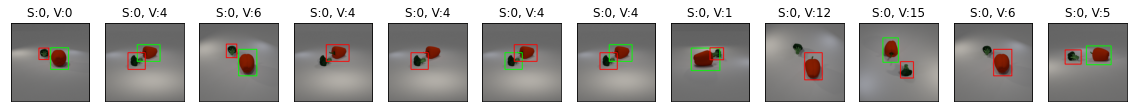

[1]


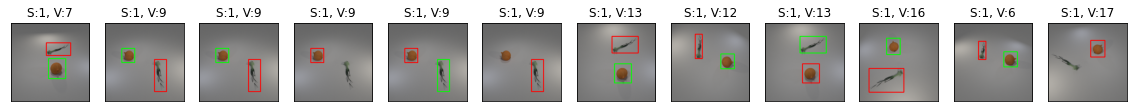

[2]


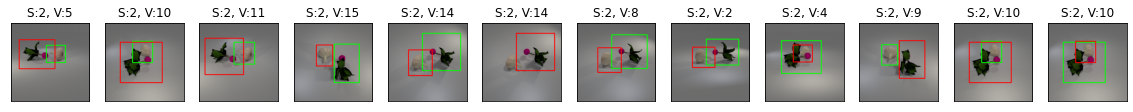

[1]


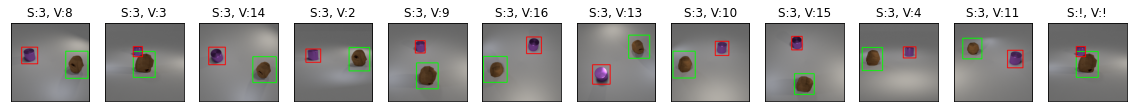

[1]


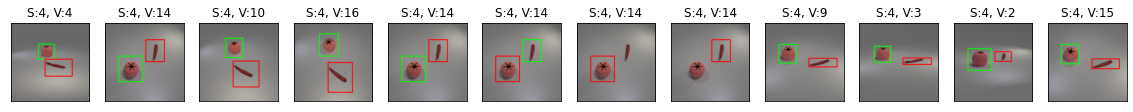

[2]


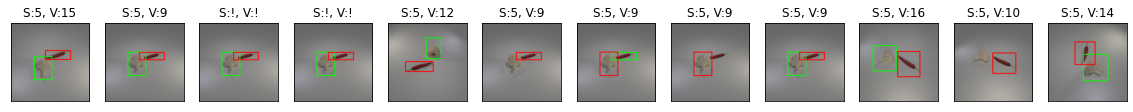

[2]


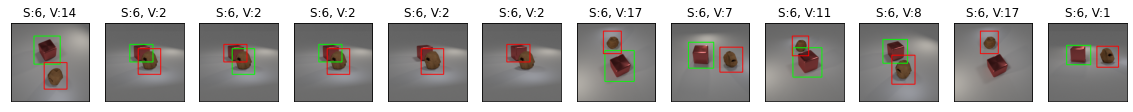

[2]


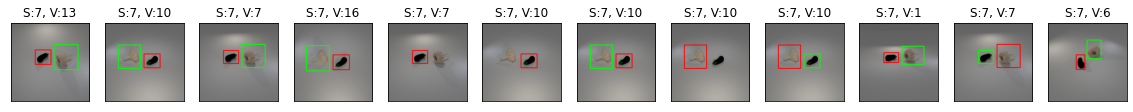

[2]


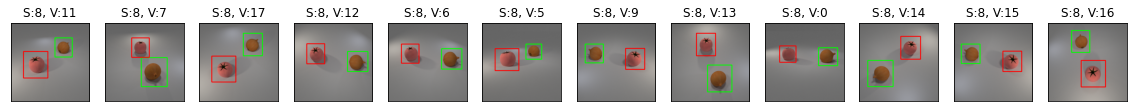

[2]


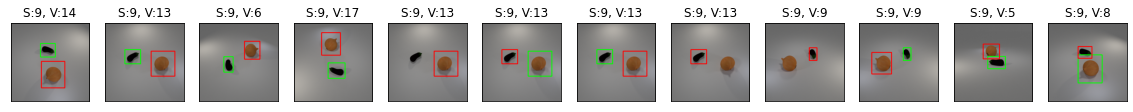

In [ ]:
pool_size = 63
pool_e_ = DoublePool_O(pool_size, isnode=False)
pool_g_ = DoublePool_O(2000, isnode=False)
pool_f_= DoublePool_O(pool_size, isnode=False)
query_train_dataset = CLEVR_train(root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5t.txt', hyp_N=2)
query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=False,collate_fn=collate_boxes)

for i, (feed_dict_q_, feed_dict_k_, metadata_) in enumerate((query_train_loader)):
    
    pool_size = 63
    pool_e_ = DoublePool_O(pool_size, isnode=False)
    pool_g_ = DoublePool_O(2000, isnode=False)
    pool_f_= DoublePool_O(pool_size, isnode=False)
    
    q_idx = metadata_["query_image_index"].item()
    k_idx = metadata_["key_image_index"].item()
    scene_num = metadata_["scene_number"].item()
    
#     q_idx = np.array((q_idx)).reshape(1,-1)
#     k_idx = np.array((k_idx)).reshape(1,-1)
#     scene_num = numpy.array((scene_num)).reshape(1,-1)
    
    #Story the scene embedding of the 0th view
    store_to_pool_e(pool_e_, feed_dict_q_, metadata_, model,args, scene_num, q_idx)
    store_to_pool_e(pool_f_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    
    #store view transformed embeddings to pool_g
    store_to_pool_g(pool_g_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    
    #Store unview transformed embeddings of the other views
    store_to_pool_e(pool_g_, feed_dict_k_, metadata_, model, args, "!", "!")
    store_to_pool_e(pool_g_, feed_dict_k_, metadata_, model, args, "!", "!")
    
    feed_dict_n_lists = sample_same_scene_negs(feed_dict_q_, feed_dict_k_, metadata_, args.hyp_N, 16)[0]
    
    for feed_dict_n,view_idx in feed_dict_n_lists:
        #Store unview transformed embeddings of the other views
        store_to_pool_e(pool_g_, feed_dict_n, metadata_, model, args, scene_num, view_idx.item())
        
    f = random_retrieve_topk(args, pool_e_, pool_g_, pool_f_, imgs_to_view=1,k=10)

In [ ]:
query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=False, collate_fn=collate_boxes)

train_iter = iter(query_train_loader)

In [ ]:
feed_q, feed_k, metadata = next(train_iter)
q_idx = metadata_["query_image_index"].item()
k_idx = metadata_["key_image_index"].item()
scene_num = metadata_["scene_number"].item()
q_idx, k_idx

(0, 1)

In [ ]:
model.eval()
with torch.no_grad():
    feat_q = model(feed_q, None, metadata, is_eval=True).cpu().numpy()
    feat_k_o = model(feed_k, None, metadata, is_eval=True).cpu().numpy()
    feat_k_t = model(feed_k, None, metadata, is_viewpoint_eval=True).cpu().numpy()

In [ ]:
from scipy.spatial import distance

In [ ]:
def get_distance(p1, p2):
    return [distance.cdist(p1[i].reshape(1,-1),p2[i].reshape(1,-1))[0][0] for i in range(4)]

In [ ]:
get_distance(feat_k_o,feat_k_t)

[0.16113399618988022,
 0.15029617432368508,
 0.13337586286469147,
 0.09776310539851771]

In [ ]:
get_distance(feat_q,feat_k_t)

[0.15480049389115194,
 0.1606578837506792,
 0.147091118649331,
 0.10524709358850218]

In [ ]:
get_distance(feat_q,feat_k_o)

[0.07934847200314589,
 0.09724928655296944,
 0.10840104478296744,
 0.0994926118924702]